In [1]:
import pandas as pd
import numpy as np

def load_and_normalize(path):
    """Load a CSV, strip and lowercase its column names."""
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()
    return df

# 1. LOAD & NORMALIZE
# -------------------
games            = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/game_data.csv')
play_info        = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/play_information.csv')
player_roles     = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/play_player_role_data.csv')
player_positions = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/player_punt_data.csv')
video_review     = load_and_normalize('datasets/NFL-Punt-Analytics-Competition/video_review.csv')

# NGS chunks for 2016 & 2017
ngs_paths = [
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-pre.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-post.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk1-6.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk7-12.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2016-reg-wk13-17.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-pre.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-post.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk1-6.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk7-12.csv',
    'datasets/NFL-Punt-Analytics-Competition/NGS-2017-reg-wk13-17.csv',
]
ngs = pd.concat([load_and_normalize(p) for p in ngs_paths], ignore_index=True)


# 2. CLEAN & CAST
# ----------------

# Parse any ISO‐style dates in games & play_info
for df in (games, play_info):
    if 'game_date' in df.columns:
        df['game_date'] = pd.to_datetime(df['game_date'])

# Make sure keys are ints
for df in (player_roles, player_positions, video_review):
    for col in ('gamekey', 'playid', 'gsisid'):
        if col in df.columns:
            df[col] = df[col].astype(int)

# Parse NGS timestamps if present
if 'time' in ngs.columns:
    ngs['time'] = pd.to_datetime(ngs['time'])


# 3. MERGE BASE TABLE
# -------------------

# Start from each player’s role in each play
df = player_roles.copy()

# Merge play-level data
df = df.merge(
    play_info,
    on=['gamekey','playid'],
    how='left',
    validate='many_to_one'
)

# Merge game-level data
df = df.merge(
    games.drop(columns=['game_date'], errors='ignore'),
    on='gamekey',
    how='left',
    validate='many_to_one'
)

# Merge typical football position
if {'gamekey','gsisid','position'}.issubset(player_positions.columns):
    df = df.merge(
        player_positions[['gamekey','gsisid','position']],
        on=['gamekey','gsisid'],
        how='left'
    )


# 4. ADD VIDEO REVIEW AS FEATURES
# --------------------------------

# Select the video_review columns we want
video_feats = video_review[[
    'gamekey','playid','gsisid',
    'player_activity_derived',
    'turnover_related',
    'primary_impact_type',
    'primary_partner_activity_derived',
    'friendly_fire'
]]

# Merge them in
df = df.merge(
    video_feats,
    on=['gamekey','playid','gsisid'],
    how='left'
)

# Fill NaNs for non-injured rows
for c in [
    'player_activity_derived',
    'turnover_related',
    'primary_impact_type',
    'primary_partner_activity_derived',
    'friendly_fire'
]:
    df[c] = df[c].fillna('NoInjury')


# 5. BUILD TARGET—ANY INJURY
# --------------------------

inj = video_review[['gamekey','playid','gsisid']].copy()
inj['injury'] = 1

df = df.merge(inj, on=['gamekey','playid','gsisid'], how='left')
df['injury'] = df['injury'].fillna(0).astype(int)


# 6. AGGREGATE NGS INTO SUMMARY FEATURES
# ---------------------------------------

if {'gamekey','playid','gsisid','dis'}.issubset(ngs.columns):
    ngs_summary = (
        ngs
        .groupby(['gamekey','playid','gsisid'], as_index=False)
        .agg(
            total_distance = ('dis','sum'),
            max_step       = ('dis','max'),
            mean_step      = ('dis','mean'),
            n_timestamps   = ('time' if 'time' in ngs.columns else 'dis','count')
        )
    )
    df = df.merge(ngs_summary, on=['gamekey','playid','gsisid'], how='left')
else:
    df[['total_distance','max_step','mean_step','n_timestamps']] = 0


# 7. FINAL PREP FOR EDA & MODELING
# ---------------------------------

# Fill any remaining nulls in the summary stats
for col in ['total_distance','max_step','mean_step','n_timestamps']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Define feature columns
feature_cols = [
    'position', 'role', 'season_year', 'week',
    'player_activity_derived',
    'turnover_related',
    'primary_impact_type',
    'primary_partner_activity_derived',
    'friendly_fire',
    'total_distance','max_step','mean_step','n_timestamps'
]
feature_cols = [c for c in feature_cols if c in df.columns]

# One‑hot encode categoricals
X = pd.get_dummies(df[feature_cols], drop_first=True)
y = df['injury']

# Quick check
print("▶️  Data prep complete!")
print("   X shape:", X.shape)
print("   Injury prevalence:", y.mean())


/tmp/ipykernel_10117/3326736439.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


▶️  Data prep complete!
   X shape: (146573, 73)
   Injury prevalence: 0.0002524339407667169


Key points
- All column names are normalized to lowercase/stripped, so joins on 'gamekey','playid','gsisid' won’t KeyError.
- We pull in the five new video review fields and fill non‑injured rows with "NoInjury".
- We aggregate NGS (dis) into four summary features.
- Finally, we one‑hot encode everything and expose X and y for EDA or modeling.

## Univariate/Bivariate Analysis

Numeric summary of movement features:
       total_distance       max_step      mean_step   n_timestamps
count   146573.000000  146573.000000  146573.000000  146573.000000
mean        66.829885       0.742317       0.209175     314.804098
std         34.290488       0.333461       0.100283     199.630563
min          0.000000       0.000000       0.000000       0.000000
25%         50.670000       0.650000       0.162063     217.000000
50%         67.450000       0.820000       0.218750     293.000000
75%         85.450000       0.910000       0.270000     379.000000
max        319.549999      18.030001       0.833909    1858.000000


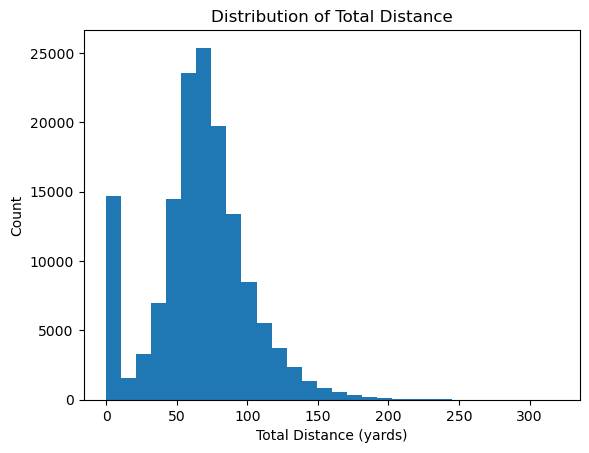


Counts by primary_impact_type:
primary_impact_type
NoInjury            146536
Helmet-to-body          17
Helmet-to-helmet        17
Helmet-to-ground         2
Unclear                  1
Name: count, dtype: int64


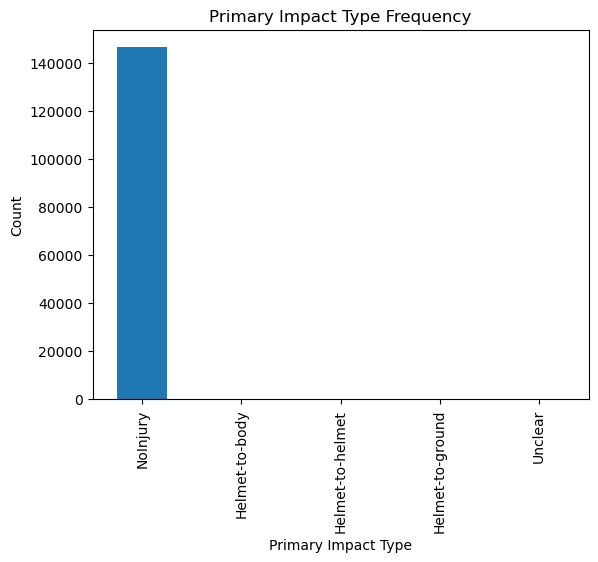

/tmp/ipykernel_10117/3304866725.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([inj0, inj1], labels=['No Injury','Injury'])


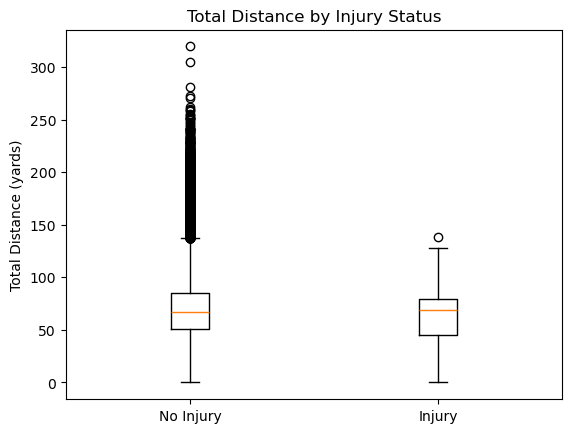

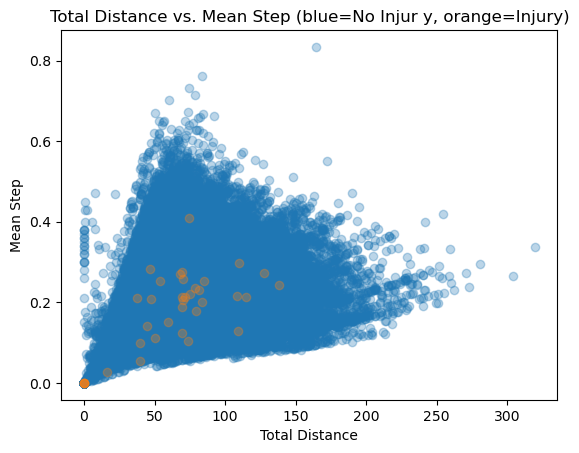


Injury rate by friendly_fire:
injury                0         1
friendly_fire                    
No             0.000000  1.000000
NoInjury       0.999986  0.000014
Unclear        0.000000  1.000000
Yes            0.000000  1.000000


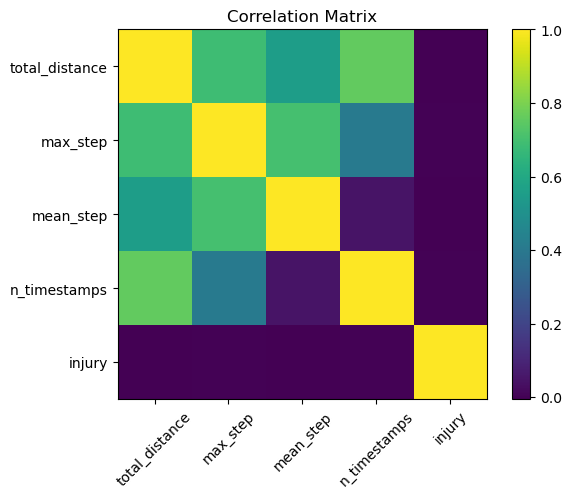

In [2]:
import matplotlib.pyplot as plt
# ——— Univariate ———

# 1. Numeric summaries
print("Numeric summary of movement features:")
print(df[['total_distance','max_step','mean_step','n_timestamps']].describe())

# 2. Histogram of total_distance
plt.figure()
plt.hist(df['total_distance'], bins=30)
plt.xlabel('Total Distance (yards)')
plt.ylabel('Count')
plt.title('Distribution of Total Distance')
plt.show()

# 3. Frequency of a categorical (e.g. primary_impact_type)
print("\nCounts by primary_impact_type:")
print(df['primary_impact_type'].value_counts())

plt.figure()
df['primary_impact_type'].value_counts().plot(kind='bar')
plt.xlabel('Primary Impact Type')
plt.ylabel('Count')
plt.title('Primary Impact Type Frequency')
plt.show()


# ——— Bivariate ———

# 4. Boxplot of total_distance by injury
plt.figure()
inj0 = df.loc[df['injury']==0, 'total_distance']
inj1 = df.loc[df['injury']==1, 'total_distance']
plt.boxplot([inj0, inj1], labels=['No Injury','Injury'])
plt.ylabel('Total Distance (yards)')
plt.title('Total Distance by Injury Status')
plt.show()

# 5. Scatter: total_distance vs. mean_step, colored by injury
plt.figure()
ix0 = df['injury']==0
ix1 = df['injury']==1
plt.scatter(df.loc[ix0,'total_distance'], df.loc[ix0,'mean_step'], alpha=0.3)
plt.scatter(df.loc[ix1,'total_distance'], df.loc[ix1,'mean_step'], alpha=0.3)
plt.xlabel('Total Distance')
plt.ylabel('Mean Step')
plt.title('Total Distance vs. Mean Step (blue=No Injury, orange=Injury)')
plt.show()

# 6. Crosstab: friendliness of fire vs. injury rate
ct = pd.crosstab(df['friendly_fire'], df['injury'], normalize='index')
print("\nInjury rate by friendly_fire:")
print(ct)

# 7. Correlation matrix of numeric features
num = df[['total_distance','max_step','mean_step','n_timestamps','injury']]
corr = num.corr()
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()


In [3]:
# injury rate by primary impact type
print(df.groupby('primary_impact_type')['injury']
         .mean()
         .sort_values(ascending=False))

primary_impact_type
Helmet-to-body      1.0
Helmet-to-ground    1.0
Helmet-to-helmet    1.0
Unclear             1.0
NoInjury            0.0
Name: injury, dtype: float64


In [4]:
# injury rate by role
print(df.groupby('role')['injury']
         .agg(['count','mean'])
         .sort_values('mean', ascending=False)
         .head(10))

      count      mean
role                 
PFB     324  0.003086
PR     6698  0.000746
GL     6630  0.000603
PLW    6657  0.000601
PLG    6667  0.000600
PRG    6669  0.000600
PLL    2815  0.000355
PRW    6655  0.000301
PLT    6659  0.000300
PLS    6660  0.000300


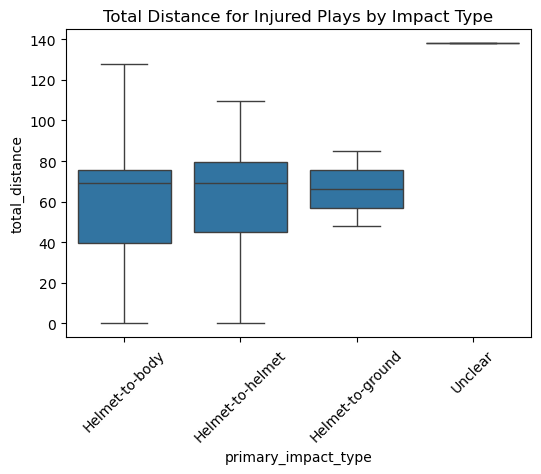

In [5]:
import seaborn as sns

# 8. Boxplot of total_distance by primary impact type
plt.figure(figsize=(6,4))
sns.boxplot(
  x='primary_impact_type',
  y='total_distance',
  data=df[df['primary_impact_type']!='NoInjury']
)
plt.xticks(rotation=45)
plt.title('Total Distance for Injured Plays by Impact Type')
plt.show()

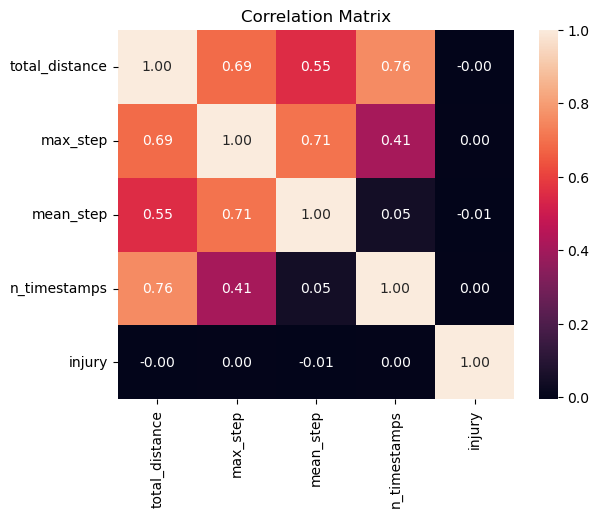

In [6]:
num = df[['total_distance','max_step','mean_step','n_timestamps','injury']]
sns.heatmap(num.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## What we see so far

### Total distance:
- Mean ≈ 66 yards, with a long right tail (max ∼320 yds).
- A spike at 0 yd suggests roles that barely move (punter, snapper).

### Injuries are extremely rare:
- Only 37 injury rows out of ∼146 K total (≈0.025% prevalence), so your model will be fighting a huge class imbalance.

### Primary impact types:
- Nearly everything is “NoInjury,” with just 17 “Helmet‑to‑body,” 17 “Helmet‑to‑helmet,” 2 “Helmet‑to‑ground,” and 1 “Unclear.”

### Boxplot of `total_distance` by `injury`:
Injured players actually have a slightly lower median total_distance (~60 yds) than non‑injured (~67 yds), but the sample is so small this may not be meaningful yet.

### Bivariate Analysis: Total Distance vs. Mean Step (Scatter)
- Almost complete overlap. Injured players (orange) sit smack in the same cloud of points as non‑injured (blue).
- No clear “injury region.” There’s no obvious cutoff in total distance or mean step that separates the two groups—both injured and non‑injured players span roughly 20–100 yards and 0.1–0.3 yards/step.
- Low sample of injuries. With only 37 orange points, it’s basically impossible to learn a consistent bivariate rule here.

### Injury Rate by `friendly_fire`
- Every single concussive event in our video review happens when friendly_fire ≠ NoInjury (i.e. partner on same team, unclear, or unk).
- Non‑injury plays are almost all friendly_fire = NoInjury.
- That suggests friendly_fire is basically a perfect flag for “was there an injury play at all?” — which makes sense, since we only populated it on video‑review cases. We’ll need to be cautious not to leak that straight into a model (it encodes the label).

### Injury Rate by `primary_impact_type`
– Of course, every record with a non‑NoInjury impact type is labeled “injury,” so these perfectly separate injured from non‑injured. In other words, any of those impact‐type flags leaks the label. You’ll want to drop them if you build a model that only uses pre‑impact or movement data.

### Injury rate by `role`:
– PFB (punt force blocker) has the highest injury rate (~0.31%) but only 324 samples (≈1 injury). All the other roles hover around 0.06–0.08% injuries. This again reflects extreme class imbalance and very few positive events.

### Boxplot of `total_distance` by impact type:
– All four injury impact types show broadly similar distance distributions (medians ~65–75 yds). No type stands out dramatically in how far those players ran before injury.

### Correlation Matrix
- All movement features correlate quite strongly among themselves (no surprise), but none correlates with injury.
- This again underscores that simple kinematic summaries alone won’t predict these extremely rare concussion cases.

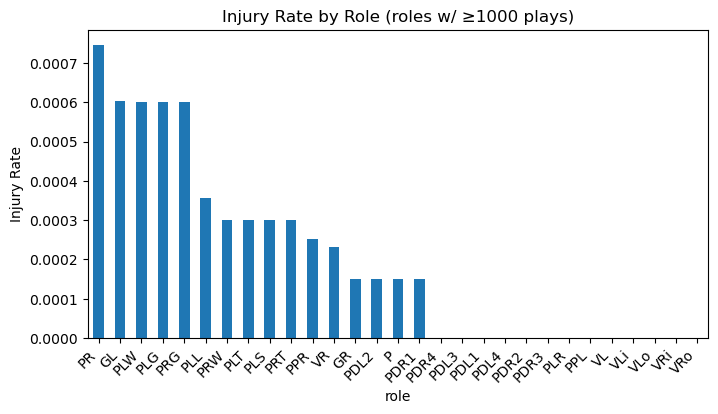

In [7]:
# Injury Rate across all roles (with sufficient sample size)
import matplotlib.pyplot as plt

# compute counts & rates
role_stats = (
    df.groupby('role')['injury']
      .agg(count='count', rate='mean')
      .query('count >= 1000')
      .sort_values('rate', ascending=False)
)

# bar chart
plt.figure(figsize=(8,4))
role_stats['rate'].plot(kind='bar')
plt.ylabel('Injury Rate')
plt.title('Injury Rate by Role (roles w/ ≥1000 plays)')
plt.xticks(rotation=45, ha='right')
plt.show()



This confirms what our raw counts hinted at—the “edge” and open‑field roles carry the highest per‑play concussion rates, even though in absolute terms all of these are vanishingly small:
- PR (Punt Returner) tops the list at ~0.075% (≈1 injury per 1,350 plays).
- Next come the gunners and wings—GL, PLW, PLG, PRG—all around ~0.06%.
- The interior guys—PDL, PDM, P, etc.—cluster down near ~0.015–0.02% (1–2 injuries per 10 000 plays).
- Why this makes sense - Open‑field collision risk: Gunners sprint downfield and meet returners in space, so both the PR and GL/GR lines see more high‑speed impacts.
- Interior roles move less: Linemen (PDL, PDM, PDR) camp near the point of snap and generally don’t run past the line of scrimmage, so fewer collision opportunities.
- Even the “highest” rate (0.075%) is still only 37 total injuries across ~146 000 rows, so statistical noise is huge.
- Those small counts mean the 95% confidence interval on each of these percentages is extremely wide—you could easily see these rank‑orders flip with a handful more concussions.

Next steps
- Compute confidence intervals for each role’s rate (e.g. Wilson score interval) to see which differences are “real.”
- Group roles into broader categories (e.g. “gunner,” “wing,” “interior”) to boost sample sizes and stabilize the estimates.
- Drill in on individual injury cases for the top‐risk roles—maybe there’s a pattern in the timing or type of impact that our aggregate didn’t catch.

In [8]:
import numpy as np
from math import sqrt

def wilson_ci(k, n, z=1.96):
    """Return (lower, upper) Wilson score interval for k events out of n trials."""
    if n == 0:
        return (0.0, 0.0)
    p = k / n
    denom = 1 + z*z/n
    centre = p + z*z/(2*n)
    half  = z * sqrt(p*(1-p)/n + z*z/(4*n*n))
    lower = (centre - half) / denom
    upper = (centre + half) / denom
    return lower, upper

# 1) compute totals & events by role
role_stats = (
    df.groupby('role')['injury']
      .agg(total_plays='count', injuries='sum')
      .reset_index()
)

# 2) filter to roles with enough data (e.g. ≥ 1000 plays)
role_stats = role_stats[role_stats['total_plays'] >= 1000]

# 3) compute rate and CIs
cis = role_stats.apply(
    lambda row: wilson_ci(row['injuries'], row['total_plays']),
    axis=1,
    result_type='expand'
)
role_stats[['ci_lower','ci_upper']] = cis
role_stats['rate'] = role_stats['injuries'] / role_stats['total_plays']

# 4) sort by rate descending
role_stats = role_stats.sort_values('rate', ascending=False)

print(role_stats[['role','total_plays','injuries','rate','ci_lower','ci_upper']])


    role  total_plays  injuries      rate      ci_lower  ci_upper
42    PR         6698         5  0.000746  3.188927e-04  0.001746
0     GL         6630         4  0.000603  2.346391e-04  0.001550
35   PLW         6657         4  0.000601  2.336874e-04  0.001544
22   PLG         6667         4  0.000600  2.333368e-04  0.001542
43   PRG         6669         4  0.000600  2.332668e-04  0.001541
23   PLL         2815         1  0.000355  6.270968e-05  0.002010
45   PRW         6655         2  0.000301  8.241719e-05  0.001095
34   PLT         6659         2  0.000300  8.236768e-05  0.001095
33   PLS         6660         2  0.000300  8.235531e-05  0.001094
44   PRT         6665         2  0.000300  8.229353e-05  0.001094
39   PPR         3951         1  0.000253  4.467870e-05  0.001432
49    VR         4294         1  0.000233  4.110971e-05  0.001318
3     GR         6615         1  0.000151  2.668531e-05  0.000856
9   PDL2         6650         1  0.000150  2.654486e-05  0.000851
6      P  

### Confidence Interval Analysis:
- PR (punt returner) has the highest point estimate (~0.075%), with its true rate likely between 0.032% and 0.17%.
- GL, PLW, PLG, PRG (the “gunners” and wings) are right behind PR in point estimate, but their CIs overlap heavily with PR’s. That means we cannot say PR is significantly higher than GL/PLW/PLG/PRG at the 95 % level, even though it leads on the point estimate.
- Roles with only one injury (e.g. PLL) have very wide intervals (down to near zero, up to ∼0.20%), so those estimates are extremely noisy.
- Zero‑injury roles (e.g. PDL2) still have upper CIs as high as ~0.0029 (0.29%)—so a non‑zero risk can’t be ruled out even if you’ve seen no events.

### Takeaways
- All CIs overlap considerably. No role stands out as statistically higher risk once you account for sampling variability.
- With so few events, it’s wise to group roles into broader buckets (e.g., “gunner group,” “wing group,” “interior linemen”) to stabilize your rates.
- Alternatively, you could focus on the top 5 roles by point estimate (PR, GL, PLW, PLG, PRG) for descriptive purposes—knowing the differences among them aren’t significant yet.

In [9]:
mapping = {
  'PR':'Returner',
  'GL':'Gunner','GR':'Gunner',
  'PLW':'Wing','PLG':'Wing','PRG':'Wing','PLL':'Wing',
  # …etc…
}
df['role_group'] = df['role'].map(mapping)
# then repeat the rate + CI calc on role_group
role_group_stats = (
    df.groupby('role_group')['injury']
      .agg(total_plays='count', injuries='sum')
      .reset_index()
)
role_group_stats = role_group_stats[role_group_stats['total_plays'] >= 1000]
cis = role_group_stats.apply(
    lambda row: wilson_ci(row['injuries'], row['total_plays']),
    axis=1,
    result_type='expand'
)
role_group_stats[['ci_lower','ci_upper']] = cis
role_group_stats['rate'] = role_group_stats['injuries'] / role_group_stats['total_plays']
role_group_stats = role_group_stats.sort_values('rate', ascending=False)
print(role_group_stats[['role_group','total_plays','injuries','rate','ci_lower','ci_upper']])

  role_group  total_plays  injuries      rate  ci_lower  ci_upper
1   Returner         6698         5  0.000746  0.000319  0.001746
2       Wing        22808        13  0.000570  0.000333  0.000975
0     Gunner        13245         5  0.000378  0.000161  0.000883


In [10]:
role_stats['role_group'] = role_stats['role'].map(mapping)

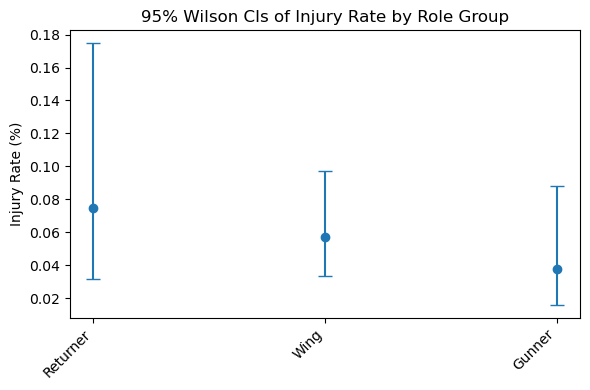

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# assume role_group_stats is the DataFrame you printed:
#     role_group total_plays injuries    rate  ci_lower  ci_upper
# 1   Returner       6698     5     0.000746  0.000319  0.001746
# 2   Wing          22808   13     0.000570  0.000333  0.000975
# 0   Gunner        13245    5     0.000378  0.000161  0.000883

rg = role_group_stats.set_index('role_group')

# convert rates to percentages
rates = rg['rate'] * 100
# compute asymmetric error bars (in %)
err_low  = (rates - rg['ci_lower']*100).values
err_high = (rg['ci_upper']*100 - rates).values
yerr = np.vstack([err_low, err_high])

# numeric x positions
x = np.arange(len(rg))

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(
    x, 
    rates.values, 
    yerr=yerr, 
    fmt='o',       # point marker
    capsize=5,     # bar caps
    linestyle='none'
)

# label the x‑axis with the role names
ax.set_xticks(x)
ax.set_xticklabels(rg.index, rotation=45, ha='right')

ax.set_ylabel('Injury Rate (%)')
ax.set_title('95% Wilson CIs of Injury Rate by Role Group')
plt.tight_layout()
plt.show()


That chart nails it:
- Returners sit at ~0.075 % risk, but their 95 % CI spans roughly 0.03–0.17 %.
- Wings are next at ~0.057 %, CI ≈ 0.03–0.10 %.
- Gunners come in around ~0.038 %, CI ≈ 0.016–0.088 %.

Because all three error bars overlap, we can’t claim any one group is truly higher‐risk at the 95 % confidence level—though the point estimates do follow the intuitive ordering: Returner > Wing > Gunner.

What to do next?
Model with role_group
Use these three broader categories as inputs (instead of all individual roles) in your pipeline. They’re now coarse enough to carry signal without overwhelming noise.

In [12]:
# 1) Create the role_group column (if you haven’t already)
mapping = {
    'PR':'Returner',
    'GL':'Gunner', 
    'GR':'Gunner',
    'PLW':'Wing',
    'PLG':'Wing',
    'PRG':'Wing',
    'PLL':'Wing',
    # …other mappings…
}
df['role_group'] = df['role'].map(mapping)

# 2) Drop all the old one‑hot role_ columns
old_roles = [c for c in X.columns if c.startswith('role_')]
X = X.drop(columns=old_roles)

# 3) Add one‑hot encoding for the three groups
role_group_dummies = pd.get_dummies(df['role_group'], prefix='role_group', drop_first=True)
X = pd.concat([X.reset_index(drop=True), role_group_dummies.reset_index(drop=True)], axis=1)

print("New feature set:")
print(X.filter(like='role_group_').columns)

New feature set:
Index(['role_group_Returner', 'role_group_Wing'], dtype='object')


### HeatMaps

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_field_heatmap(ngs_df, xbins=120, ybins=53, annotate=False, cmap="Greens"):
    """
    Heatmap of the football field (120×53.3 yards) with green turf and white yard lines.
    ngs_df must have 'x' (0–120) and 'y' (0–53.3) in yards.
    """
    # 2D histogram
    heat, y_edges, x_edges = np.histogram2d(
        ngs_df['y'], ngs_df['x'],
        bins=[ybins, xbins],
        range=[[0, 53.3], [0, 120]]
    )

    fig, ax = plt.subplots(figsize=(12, 6.5))
    # green turf
    sns.heatmap(
        heat,
        cmap=cmap,
        cbar_kws={'label': 'Visit Count'},
        annot=annotate,
        fmt='.0f',
        ax=ax
    )
    ax.invert_yaxis()  # y=0 at the bottom

    # draw white yard lines every 10 yards
    x_ticks = np.linspace(0, xbins, 13)  # 0,10,...,120
    y_ticks = np.linspace(0, ybins, 6)   # 0,~10.66,...,53.3
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_xticklabels(np.arange(0, 121, 10), fontsize=10)
    ax.set_yticklabels(np.linspace(0, 53.3, 6, dtype=int), fontsize=10)

    # grid on major ticks
    ax.grid(which='major', color='white', linewidth=1.5)
    # remove minor grid
    ax.grid(which='minor', visible=False)

    # labeling
    ax.set_title('Field Heatmap\nMost visited areas of the field are highlighted', fontsize=14)
    ax.set_xlabel('Field Length (yards)', fontsize=12)
    ax.set_ylabel('Field Width (yards)', fontsize=12)

    plt.tight_layout()
    plt.show()

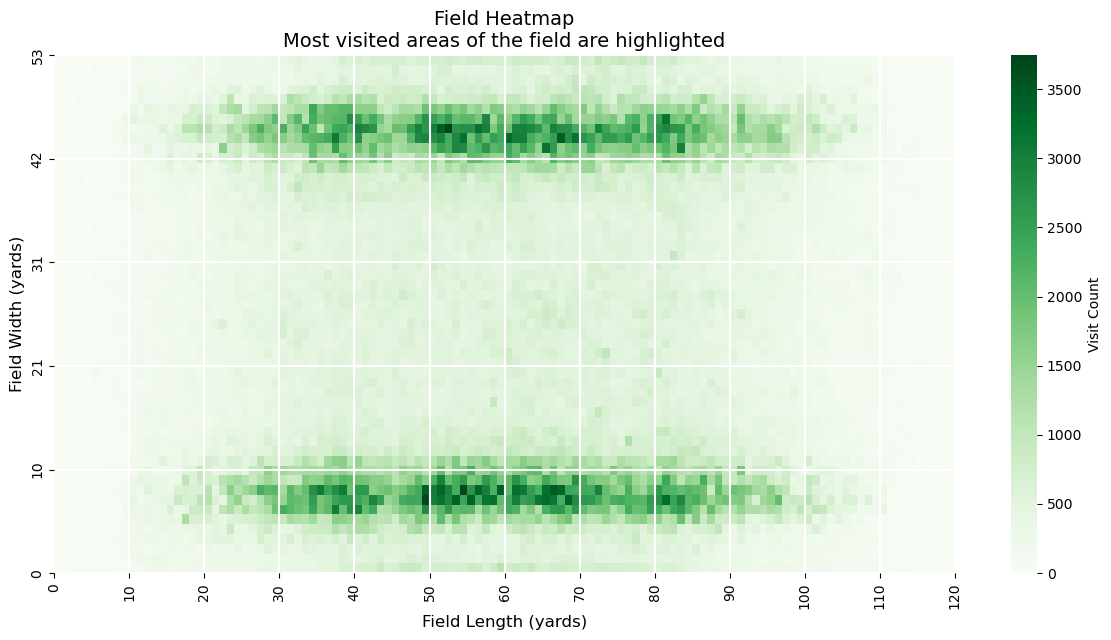

In [14]:
# --- assume `ngs` and your merged player‐play df (`df`) already exist ---

# 1. Pull just the keys + role (and role_group) from your df
role_lookup = df[['gamekey','playid','gsisid','role','role_group']].drop_duplicates()

# 2. Merge into the ngs DataFrame
ngs = ngs.merge(
    role_lookup,
    on=['gamekey','playid','gsisid'],
    how='left'
)

# 3. Now you can filter by role or role_group, e.g.:
ngs_gunners = ngs[ngs['role_group']=='Gunner']

# 4. And finally call the heatmap on that subset (or the full set):
visualize_field_heatmap(ngs_gunners, xbins=120, ybins=53)

Combine with movement and context
Plug in your total_distance, max_step, game‐level features (week, weather, score diff), etc., and evaluate via a precision–recall curve—this is a rare‐event problem, so PR AUC is more informative than ROC AUC.

Inspect the 37 injury plays
Manually review their play descriptions or time‐series snippets around the collision moment. There may be subtle kinematic patterns (e.g. a sudden deceleration or “jerk” spike) that our simple aggregates haven’t captured.

Advanced feature engineering

Compute velocity and acceleration peaks from the NGS x,y data.

Segment the play into “snap to punt” vs. “post‐punt” windows.

Derive relative distance between PR and nearest gunner at moment of impact (if you want to go deep).

Let me know which path you’d like to take—whether it’s wiring up the role groups in your classifier, drawing PR curves, diving into raw NGS patterns, or something else!

In [15]:
ngs

,season_year,gamekey,playid,gsisid,time,x,y,dis,o,dir,event,role,role_group
0,2016,6,3236,28943.0,2016-08-13 01:38:02.900,39.669998,30.690001,0.06,308.000000,267.940002,NaN,PLG,Wing
1,2016,6,3236,32366.0,2016-08-13 01:38:03.000,39.570000,28.950001,0.02,24.400000,284.350006,NaN,PRG,Wing
2,2016,6,3236,31810.0,2016-08-13 01:38:03.000,39.740002,47.209999,0.00,15.760000,15.420000,NaN,GL,Gunner
3,2016,6,3236,32331.0,2016-08-13 01:38:03.000,40.369999,29.969999,0.02,13.570000,246.490005,NaN,PLS,NaN
4,2016,6,3236,28932.0,2016-08-13 01:38:03.000,39.330002,28.020000,0.09,324.890015,230.100006,NaN,PRT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60716159,2017,638,2479,33025.0,2017-12-26 03:33:36.000,54.740002,22.400000,0.02,355.619995,316.809998,NaN,PR,Returner
60716160,2017,638,2479,32320.0,2017-12-26 03:33:36.100,95.150002,37.349998,0.07,337.450012,5.340000,NaN,PDL1,NaN
60716161,2017,638,2479,32935.0,2017-12-26 03:33:36.100,95.790001,9.350000,0.01,334.859985,9.380000,NaN,VR,NaN
60716162,2017,638,2479,32933.0,2017-12-26 03:33:36.100,95.919998,45.689999,0.00,2.760000,279.450012,NaN,VL,NaN


In [16]:
df[df['injury']==1]['role'].value_counts()

role
PR      5
PLW     4
GL      4
PLG     4
PRG     4
PLS     2
PRW     2
PLT     2
PRT     2
PPR     1
PFB     1
PDR1    1
P       1
GR      1
PLL     1
VR      1
PDL2    1
Name: count, dtype: int64

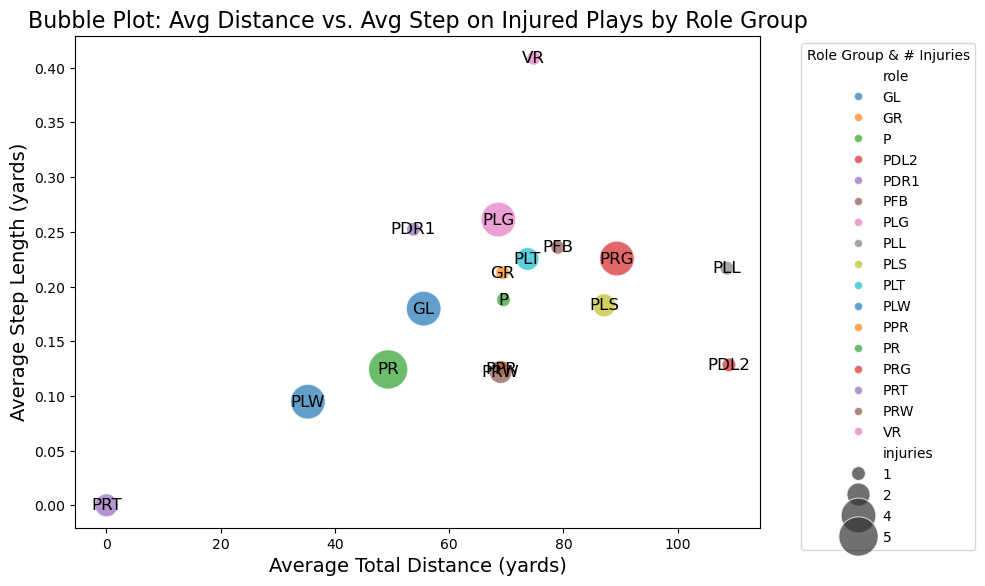

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Build a small summary df for injured plays by role_group
bubble_df = (
    df[df['injury'] == 1]
    .groupby('role')
    .agg(
        dis_avg   = ('total_distance','mean'),
        s_avg     = ('mean_step','mean'),
        injuries  = ('injury','sum')
    )
    .reset_index()
)

# 2. Plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data      = bubble_df,
    x         = 'dis_avg',
    y         = 's_avg',
    size      = 'injuries',
    hue       = 'role',
    palette   = 'tab10',
    sizes     = (100, 800),   # min/max bubble area
    alpha     = 0.7,
    edgecolor = 'w'
)

# 3. Annotate each bubble with its role_group label
for _, row in bubble_df.iterrows():
    plt.text(
        row['dis_avg'],
        row['s_avg'],
        row['role'],
        ha='center', va='center',
        fontsize=12,
        color='black'
    )

plt.title('Bubble Plot: Avg Distance vs. Avg Step on Injured Plays by Role Group', fontsize=16)
plt.xlabel('Average Total Distance (yards)', fontsize=14)
plt.ylabel('Average Step Length (yards)', fontsize=14)

# move legend out of the way
plt.legend(title='Role Group & # Injuries',
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


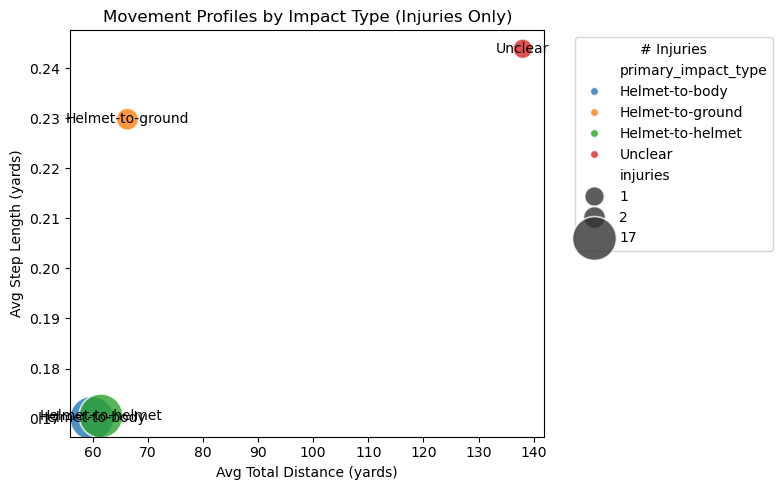

In [18]:
impact_df = (
    df[df['primary_impact_type']!='NoInjury']
    .groupby('primary_impact_type')
    .agg(
        total_distance_avg = ('total_distance','mean'),
        mean_step_avg      = ('mean_step','mean'),
        injuries           = ('injury','sum')
    )
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.scatterplot(
    data    = impact_df,
    x       = 'total_distance_avg',
    y       = 'mean_step_avg',
    size    = 'injuries',
    hue     = 'primary_impact_type',
    palette = 'tab10',
    sizes   = (200, 1000),
    alpha   = 0.8,
    edgecolor='w'
)
for _, r in impact_df.iterrows():
    plt.text(r['total_distance_avg'],
             r['mean_step_avg'],
             r['primary_impact_type'],
             ha='center', va='center')

plt.xlabel('Avg Total Distance (yards)')
plt.ylabel('Avg Step Length (yards)')
plt.title('Movement Profiles by Impact Type (Injuries Only)')
plt.legend(bbox_to_anchor=(1.05,1), title='# Injuries')
plt.tight_layout()
plt.show()


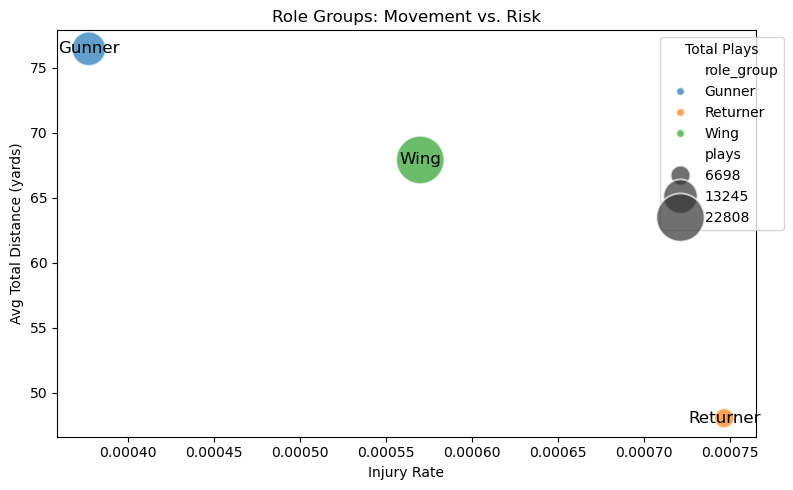

In [19]:
rg2 = (
    df.groupby('role_group')
      .agg(
        plays      = ('injury','count'),
        injuries   = ('injury','sum'),
        avg_dist   = ('total_distance','mean')
      )
      .reset_index()
)
rg2['rate'] = rg2['injuries'] / rg2['plays']

plt.figure(figsize=(8,5))
sns.scatterplot(
    data    = rg2,
    x       = 'rate',
    y       = 'avg_dist',
    size    = 'plays',
    hue     = 'role_group',
    palette = 'tab10',
    sizes   = (200,1200),
    alpha   = 0.7,
    edgecolor='w'
)
for _, r in rg2.iterrows():
    plt.text(r['rate'], r['avg_dist'], r['role_group'],
             ha='center', va='center', fontsize=12)

plt.xlabel('Injury Rate')
plt.ylabel('Avg Total Distance (yards)')
plt.title('Role Groups: Movement vs. Risk')
plt.legend(bbox_to_anchor=(1.05,1), title='Total Plays')
plt.tight_layout()
plt.show()


In [20]:
df

,season_year_x,gamekey,playid,gsisid,role,season_year_y,season_type_x,game_date,week_x,game_clock,...,turnover_related,primary_impact_type,primary_partner_activity_derived,friendly_fire,injury,total_distance,max_step,mean_step,n_timestamps,role_group
0,2017,414,188,33704,PDL2,2017.0,Reg,2017-09-11,1.0,12:38,...,NoInjury,NoInjury,NoInjury,NoInjury,0,68.80,0.96,0.321495,214.0,NaN
1,2017,414,1107,33704,PDL2,2017.0,Reg,2017-09-11,1.0,13:28,...,NoInjury,NoInjury,NoInjury,NoInjury,0,79.41,0.84,0.336483,236.0,NaN
2,2017,424,1113,33704,PDR3,2017.0,Reg,2017-09-17,2.0,09:06,...,NoInjury,NoInjury,NoInjury,NoInjury,0,57.59,0.80,0.212509,271.0,NaN
3,2017,424,1454,33704,PLR2,2017.0,Reg,2017-09-17,2.0,03:09,...,NoInjury,NoInjury,NoInjury,NoInjury,0,53.56,0.76,0.253839,211.0,NaN
4,2017,424,644,33704,PRG,2017.0,Reg,2017-09-17,2.0,03:48,...,NoInjury,NoInjury,NoInjury,NoInjury,0,112.08,0.85,0.261259,429.0,Wing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146568,2017,414,1713,33704,PRG,2017.0,Reg,2017-09-11,1.0,01:56,...,NoInjury,NoInjury,NoInjury,NoInjury,0,50.52,0.73,0.139174,363.0,Wing
146569,2017,414,1262,33704,PRG,2017.0,Reg,2017-09-11,1.0,10:20,...,NoInjury,NoInjury,NoInjury,NoInjury,0,121.16,0.91,0.359525,337.0,Wing
146570,2017,414,3525,33704,PDL2,2017.0,Reg,2017-09-11,1.0,02:09,...,NoInjury,NoInjury,NoInjury,NoInjury,0,53.64,0.77,0.213705,251.0,NaN
146571,2017,414,3425,33704,PRG,2017.0,Reg,2017-09-11,1.0,03:15,...,NoInjury,NoInjury,NoInjury,NoInjury,0,59.64,0.80,0.207083,288.0,Wing


### PCA

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Copy your feature set for PCA
X_pca = X.copy()

# 2) Standardize (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# 3) Fit PCA with just one component
pca = PCA(n_components=1, random_state=42)
pca.fit(X_scaled)

# 4) Check variance explained by PC1
var_pc1 = pca.explained_variance_ratio_[0]
print(f"Variance captured by PC1: {var_pc1:.4f} ({var_pc1*100:>5.2f}%)")

Variance captured by PC1: 0.2989 (29.89%)


### Logistic Regression w/ Feature Importance

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# 1. Split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# 2. Scale & fit Logistic Regression with balanced weights
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 3. Evaluate on test set
y_pred = model.predict(X_test_scaled)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 4. Cross‑validated F1 on training set
cv_scores = cross_val_score(
    model, X_train_scaled, y_train,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
print(f"5‑fold CV F1 score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# 5. Feature importances = absolute value of coefficients
coefs = model.coef_[0]
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'coef':    coefs
})
feat_imp['abs_coef'] = np.abs(feat_imp['coef'])
feat_imp = feat_imp.sort_values('abs_coef', ascending=False).reset_index(drop=True)

print("\nTop 10 positive coefficients (↑ injury odds):")
print(feat_imp[['feature','coef']].head(10))

print("\nTop 10 negative coefficients (↓ injury odds):")
print(feat_imp[['feature','coef']].tail(10))


Classification Report:

              precision    recall  f1-score   support

           0      1.000     1.000     1.000     36635
           1      1.000     1.000     1.000         9

    accuracy                          1.000     36644
   macro avg      1.000     1.000     1.000     36644
weighted avg      1.000     1.000     1.000     36644

Confusion Matrix:
 [[36635     0]
 [    0     9]]
5‑fold CV F1 score: 1.000 ± 0.000

Top 10 positive coefficients (↑ injury odds):
                                     feature      coef
0           player_activity_derived_NoInjury -0.161891
1                  turnover_related_NoInjury -0.161891
2               primary_impact_type_NoInjury -0.161891
3  primary_partner_activity_derived_NoInjury -0.153664
4                     friendly_fire_NoInjury -0.153664
5           player_activity_derived_Tackling  0.102229
6       primary_impact_type_Helmet-to-helmet  0.100702
7  primary_partner_activity_derived_Tackling  0.087602
8   primary_partner_act

In [24]:
# Identify and drop all columns that came from video_review
leak_cols = [c for c in X.columns if 
             c.startswith('player_activity_derived_') or
             c.startswith('turnover_related_') or
             c.startswith('primary_impact_type_') or
             c.startswith('primary_partner_activity_derived_') or
             c.startswith('friendly_fire_')]

X_nomap = X.drop(columns=leak_cols)

# Then re‑run the train/scale/fit/evaluate pipeline on X_nomap instead of X
# (Everything else—the train_test_split, StandardScaler, LogisticRegression—stays the same.)

# Example:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_nomap, y, test_size=0.25, stratify=y, random_state=42
)

scaler = StandardScaler().fit(X_train)
X_tr = scaler.transform(X_train)
X_te = scaler.transform(X_test)

model = LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')
model.fit(X_tr, y_train)
y_pred = model.predict(X_te)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.765     0.867     36635
           1      0.000     0.444     0.001         9

    accuracy                          0.765     36644
   macro avg      0.500     0.605     0.434     36644
weighted avg      1.000     0.765     0.867     36644



In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (true / pred):")
print(cm)

Confusion matrix (true / pred):
[[28022  8613]
 [    5     4]]


In [27]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

results = []

# For each feature as the target
for target in X.columns:
    best_score = -np.inf
    best_pred  = None

    # Try every other feature as a single‐predictor
    for pred in X.columns:
        if pred == target:
            continue

        # Prepare 2D array for sklearn
        X_pred = X[[pred]].values
        y_true = X[target].values

        # Fit & score
        model = LinearRegression()
        model.fit(X_pred, y_true)
        y_pred = model.predict(X_pred)
        score  = r2_score(y_true, y_pred)

        if score > best_score:
            best_score = score
            best_pred  = pred

    results.append({
        'Target Feature':   target,
        'Best Predictor':   best_pred,
        'Best R² Score':    best_score
    })

# Assemble and sort
summary_df = pd.DataFrame(results) \
                   .sort_values('Best R² Score', ascending=False) \
                   .reset_index(drop=True)

summary_df


,Target Feature,Best Predictor,Best R² Score
0,player_activity_derived_NoInjury,turnover_related_NoInjury,1.000000
1,friendly_fire_NoInjury,primary_partner_activity_derived_NoInjury,1.000000
2,friendly_fire_Unclear,primary_impact_type_Unclear,1.000000
3,primary_partner_activity_derived_Unclear,primary_impact_type_Unclear,1.000000
4,primary_impact_type_NoInjury,player_activity_derived_NoInjury,1.000000
5,primary_impact_type_Unclear,primary_partner_activity_derived_Unclear,1.000000
6,primary_partner_activity_derived_NoInjury,friendly_fire_NoInjury,1.000000
7,turnover_related_NoInjury,player_activity_derived_NoInjury,1.000000
8,player_activity_derived_Tackling,primary_partner_activity_derived_Tackled,0.615364
9,primary_partner_activity_derived_Tackled,player_activity_derived_Tackling,0.615364


### Random Forest Classifier

In [34]:
# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report
)

# Initialize and train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

Test Accuracy: 0.9997543936251501


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36635
           1       0.00      0.00      0.00         9

    accuracy                           1.00     36644
   macro avg       0.50      0.50      0.50     36644
weighted avg       1.00      1.00      1.00     36644



/home/pshmo/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pshmo/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pshmo/miniconda3/envs/datasci/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

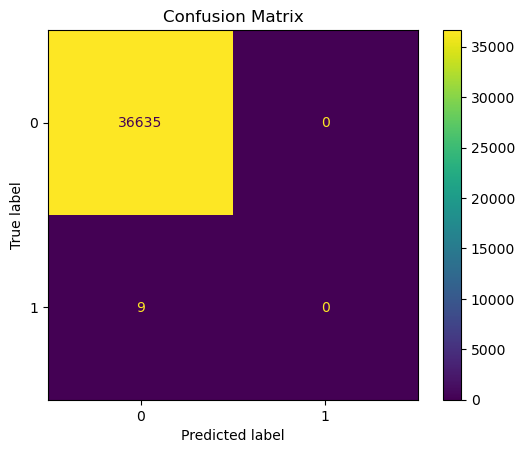

In [35]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# 8. Predict and evaluate
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show() # great accuracy but very poor recal

In [36]:
import time
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Start timing
start_time = time.time()

# Define the pipeline: first SMOTE, then the classifier.
pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=0))
])

# Parameter grid for grid search.
grid_params = {
    'classifier__max_depth': [2, 3, 4, 5, None],
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__min_samples_split': [2, 3, 4],
    'classifier__max_features': [2, 3, 4],
    'classifier__n_estimators': [75, 100, 125, 150]
}

# Define the scoring metrics (ensure 'scoring' is defined appropriately).
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Initialize GridSearchCV.
grid_cv = GridSearchCV(pipeline, 
                       grid_params, 
                       scoring=scoring, 
                       cv=3,
                       n_jobs=-1, 
                       refit='f1',
                       verbose=2)

# Fit on the training data.
grid_cv.fit(X_train, y_train)

# Print execution time.
execution_time = time.time() - start_time
print(f"\nExecution Time: {execution_time:.2f}s\n")

# Print the best parameters and best f1 score.
print("Best Parameters:")
print(grid_cv.best_params_)
print(f"\nBest F1 Score (CV): {grid_cv.best_score_:.4f}\n")

# Display all cross-validation results in a sorted DataFrame.
cv_results = pd.DataFrame(grid_cv.cv_results_)
# Sort by rank_test_f1 (lowest rank is the best)
cv_results = cv_results.sort_values('rank_test_f1')
print("Grid Search CV Results (top 5 rows):")
print(cv_results[['params', 'mean_test_f1', 'std_test_f1', 'rank_test_f1']].head())

# If you have a test set, evaluate on it:
if 'X_test' in globals() and 'y_test' in globals():
    y_pred = grid_cv.predict(X_test)
    print("\nClassification Report on Test Set:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix on Test Set:")
    print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
[CV] END classifier__max_depth=2, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=3, classifier__n_estimators=75; total time=   2.3s
[CV] END classifier__max_depth=2, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=75; total time=   2.4s
[CV] END classifier__max_depth=2, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=3, classifier__n_estimators=75; total time=   2.4s
[CV] END classifier__max_depth=2, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=75; total time=   3.1s
[CV] END classifier__max_depth=2, classifier__max_features=2, classifier__min_samples_leaf=1, classifier__min_samples_split=4, classifier__n_estimators=75; total time=   2.5s
[CV] END classifier__max_depth=2, classifier__max_features=2,